In this file, we recreate the experiment done by Lorenz et Coecke, but rewrite them using Lambeq. 
Then, using DisCoPy methods, we extract the trained circuit parameters to see to what extent they are storing semantics. 

In [25]:
BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

In [26]:
# Import all kinds of lambeq stuff 
from lambeq.backend.grammar import (Box, Cap, Cup, Diagram, Diagrammable,
                                    Functor, grammar, Id, Spider, Swap,
                                    Ty, Word)
from lambeq.backend.drawing import draw
import matplotlib.pyplot as plt
import matplotlib
from lambeq import AtomicType

# optimising the diagram to make the resulting quanutm circuit less complex
from lambeq import RemoveSwapsRewriter, RemoveCupsRewriter
from lambeq import Rewriter 

# creating the quantum circuit
from lambeq import IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

import numpy as np

# amplitude Encoding
from qiskit import QuantumCircuit

In [27]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

In [28]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/mc_train_data.txt')
test_labels, test_data = read_data('../datasets/mc_test_data.txt')
val_labels, val_data = read_data('../datasets/mc_dev_data.txt')


# here, we can choose between either the original dataset by Coecke et al. or the new one for Gijs' data

gijs = True

if not gijs: 
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/newTestSentences.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/newTrainSentences.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/newValSentences.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


if gijs:
    # new way, maybe the things after the words confused lambeq in creating the diagrams 
    with open('../datasets/testGijs.txt', 'r') as file: 
        test_data = file.readlines()
    with open('../datasets/trainGijs.txt', 'r') as file: 
        train_data = file.readlines()
    with open('../datasets/valGijs.txt', 'r') as file: 
        val_data = file.readlines()

    test_data = [sentence.strip() for sentence in test_data]
    train_data = [sentence.strip() for sentence in train_data]
    val_data = [sentence.strip() for sentence in val_data]


In [29]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


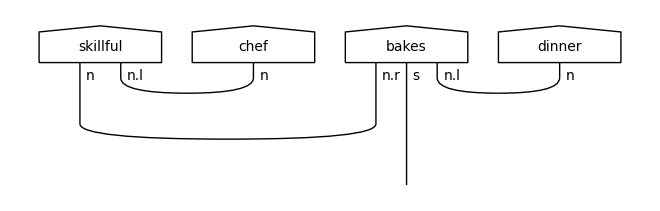

In [30]:
raw_train_diagrams[1].draw()

In [31]:
# normalising 

from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_val_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]



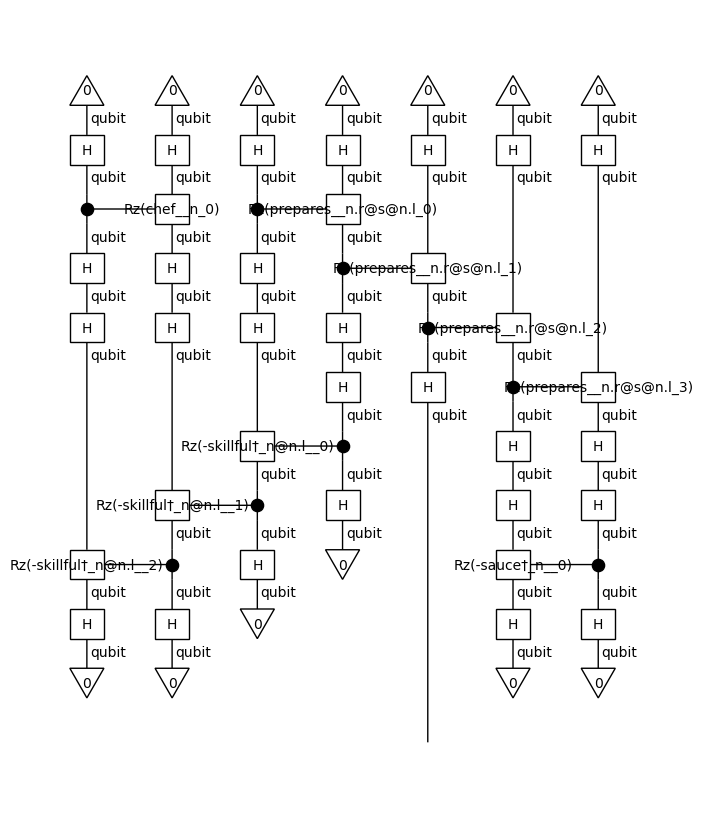

In [32]:
# create quantum circuits

from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

In [33]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
modelPennylane = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
modelPennylane.initialise_weights()



In [34]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)
                          
val_dataset = Dataset(val_circuits, val_labels)

In [35]:
def accPL(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [36]:
from lambeq import PytorchTrainer
import torch

trainerPennylane = PytorchTrainer(
    model=modelPennylane,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': accPL},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [37]:
# trainer.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

trainerPennylane.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.2002   valid/loss: 0.2074   train/acc: 0.7143   valid/acc: 0.6333
Epoch 2:    train/loss: 0.0400   valid/loss: 0.1209   train/acc: 0.8857   valid/acc: 0.8667
Epoch 3:    train/loss: 0.0310   valid/loss: 0.0922   train/acc: 0.9143   valid/acc: 0.8667
Epoch 4:    train/loss: 0.0762   valid/loss: 0.0822   train/acc: 0.9571   valid/acc: 0.8667
Epoch 5:    train/loss: 0.0622   valid/loss: 0.0797   train/acc: 0.9714   valid/acc: 0.9000
Epoch 6:    train/loss: 0.1253   valid/loss: 0.0788   train/acc: 0.9714   valid/acc: 0.9000
Epoch 7:    train/loss: 0.0170   valid/loss: 0.0635   train/acc: 0.9714   valid/acc: 0.9333
Epoch 8:    train/loss: 0.0110   valid/loss: 0.0484   train/acc: 0.9857   valid/acc: 0.9333
Epoch 9:    train/loss: 0.0108   valid/loss: 0.0494   train/acc: 1.0000   valid/acc: 0.9333
Epoch 10:   train/loss: 0.0330   valid/loss: 0.0400   train/acc: 0.9857   valid/acc: 0.9333
Epoch 11:   train/loss: 0.0598   valid/loss: 0.0278   train/acc: 0.9714   valid/

In [38]:
# Do the same thing, but now using the NUMPY model! 

from lambeq import NumpyModel

modelNumpy = NumpyModel.from_diagrams(all_circuits, use_jit=False)


from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()

accNP = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": accNP}


# NUMPY model uses QuantumTrainer class 

from lambeq import QuantumTrainer, SPSAOptimizer

trainerNumpy = QuantumTrainer(
    modelNumpy,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)




In [39]:
# train the numpy model 

trainerNumpy.fit(train_dataset, val_dataset)

Epoch 1:    train/loss: 0.3730   valid/loss: 0.6464   train/acc: 0.5143   valid/acc: 0.6000
Epoch 2:    train/loss: 0.5193   valid/loss: 0.4610   train/acc: 0.8143   valid/acc: 0.8000
Epoch 3:    train/loss: 0.4817   valid/loss: 0.4365   train/acc: 0.7571   valid/acc: 0.8333
Epoch 4:    train/loss: 0.3787   valid/loss: 0.4475   train/acc: 0.8000   valid/acc: 0.8000
Epoch 5:    train/loss: 0.2546   valid/loss: 0.4046   train/acc: 0.8429   valid/acc: 0.8667
Epoch 6:    train/loss: 0.4106   valid/loss: 0.4074   train/acc: 0.8429   valid/acc: 0.8333
Epoch 7:    train/loss: 0.2441   valid/loss: 0.3992   train/acc: 0.8286   valid/acc: 0.8667
Epoch 8:    train/loss: 0.3464   valid/loss: 0.3694   train/acc: 0.9000   valid/acc: 0.8667
Epoch 9:    train/loss: 0.2254   valid/loss: 0.3321   train/acc: 0.8571   valid/acc: 0.9333
Epoch 10:   train/loss: 0.2871   valid/loss: 0.3348   train/acc: 0.8857   valid/acc: 0.8667
Epoch 11:   train/loss: 0.3005   valid/loss: 0.3145   train/acc: 0.9143   valid/

In [40]:
'''
Same thing, but for Tket model 
'''

from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

modelTK = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

from lambeq import BinaryCrossEntropyLoss

# Using the builtin binary cross-entropy error from lambeq
bceTK = BinaryCrossEntropyLoss()

accTK = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metricsTK = {"acc": accTK}

from lambeq import QuantumTrainer, SPSAOptimizer

trainerTK = QuantumTrainer(
    modelTK,
    loss_function=bceTK,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.001*EPOCHS},
    evaluate_functions=eval_metricsTK,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)


trainerTK.fit(train_dataset, val_dataset)#, early_stopping_interval=10)

Epoch 1:    train/loss: 3.6448   valid/loss: 1.3661   train/acc: 0.5429   valid/acc: 0.5667
Epoch 2:    train/loss: 0.6176   valid/loss: 1.2791   train/acc: 0.5357   valid/acc: 0.6500
Epoch 3:    train/loss: 0.7019   valid/loss: 0.5802   train/acc: 0.5000   valid/acc: 0.6667
Epoch 4:    train/loss: 0.9620   valid/loss: 2.6727   train/acc: 0.5429   valid/acc: 0.4833
Epoch 5:    train/loss: 1.4778   valid/loss: 4.5454   train/acc: 0.6214   valid/acc: 0.6333
Epoch 6:    train/loss: 1.6701   valid/loss: 2.0406   train/acc: 0.5286   valid/acc: 0.5167
Epoch 7:    train/loss: 0.3303   valid/loss: 3.4217   train/acc: 0.7357   valid/acc: 0.4667
Epoch 8:    train/loss: 1.6975   valid/loss: 2.6237   train/acc: 0.6357   valid/acc: 0.5333
Epoch 9:    train/loss: 3.5163   valid/loss: 2.7413   train/acc: 0.6643   valid/acc: 0.5833
Epoch 10:   train/loss: 0.3662   valid/loss: 1.3796   train/acc: 0.7214   valid/acc: 0.5167
Epoch 11:   train/loss: 1.4987   valid/loss: 1.3834   train/acc: 0.6714   valid/

In [52]:
'''
Before we look at the results of the training, let us understand what exactly these circuits are that we trained above. 

We start by extracting the parameters for the symbols learned by Coecke et al. 


'''

# The symbols are the names of the respective parameters for the respective words
smbls = modelPennylane.symbols

# And the weights are their respective values 
weights = modelPennylane.weights

print('symbols: ', smbls)
print('weights: ', weights)

# now, we are only interested in the noun weights 

newSmbls = []
newWeights = []

verbSmbls = []
verbWeights = []

adjSmbls = []
adjWeights = []

for i in range(len(weights)): 
    if '__n_' in str(smbls[i]) or '†_n__' in str(smbls[i]):
        newSmbls.append(smbls[i])
        newWeights.append(weights[i].item())
    elif 'TV' in str(smbls[i]): 
        verbSmbls.append(smbls[i])
        verbWeights.append(weights[i].item())
    elif 'ADJ' in str(smbls[i]): 
        adjSmbls.append(smbls[i])
        adjWeights.append(weights[i].item())


# create a simple dictionary for parameters and weights 
parameterDict = {}
for i in range(len(smbls)):
    parameterDict[str(smbls[i])] = weights[i].item()

print(parameterDict)

import pickle

with open('../datasets/weightsDictPLGijs2QB.pkl', 'wb') as fp:
    pickle.dump(parameterDict, fp)


print(newSmbls)
print(newWeights)


symbols:  [application__n_0, application†_n__0, bakes__n.r@s@n.l_0, bakes__n.r@s@n.l_1, bakes__n.r@s@n.l_2, bakes__n.r@s@n.l_3, chef__n_0, chef†_n__0, cooks__n.r@s@n.l_0, cooks__n.r@s@n.l_1, cooks__n.r@s@n.l_2, cooks__n.r@s@n.l_3, dinner__n_0, dinner†_n__0, meal__n_0, meal†_n__0, person__n_0, person†_n__0, prepares__n.r@s@n.l_0, prepares__n.r@s@n.l_1, prepares__n.r@s@n.l_2, prepares__n.r@s@n.l_3, program__n_0, programmer__n_0, programmer†_n__0, program†_n__0, reads__n.r@s@n.l_0, reads__n.r@s@n.l_1, reads__n.r@s@n.l_2, reads__n.r@s@n.l_3, runs__n.r@s@n.l_0, runs__n.r@s@n.l_1, runs__n.r@s@n.l_2, runs__n.r@s@n.l_3, sauce__n_0, sauce†_n__0, skillful†_n@n.l__0, skillful†_n@n.l__1, skillful†_n@n.l__2, software__n_0, software†_n__0, tasty†_n@n.l__0, tasty†_n@n.l__1, tasty†_n@n.l__2, useful†_n@n.l__0, useful†_n@n.l__1, useful†_n@n.l__2]
weights:  ParameterList(
    (0): Parameter containing: [torch.float32 of size ]
    (1): Parameter containing: [torch.float32 of size ]
    (2): Parameter con

Symbol =  application__n_0
Statevector =  Statevector([0.78930432-0.45062601j, 0.08884906-0.40748097j],
            dims=(2,))
Symbol =  chef†_n__0
Statevector =  Statevector([0.90634486+0.050109j  , 0.00497008-0.41952757j],
            dims=(2,))
Symbol =  meal__n_0
Statevector =  Statevector([0.91171508-0.25812859j, 0.02992927-0.31819725j],
            dims=(2,))
Symbol =  person†_n__0
Statevector =  Statevector([ 0.82797277-0.32769708j, -0.07903394-0.44813987j],
            dims=(2,))
Symbol =  programmer†_n__0
Statevector =  Statevector([ 0.84361362-0.46071961j, -0.07773323-0.264596j  ],
            dims=(2,))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Symbol =  sauce†_n__0
Statevector =  Statevector([0.72998412+0.02779591j, 0.00630923-0.68286951j],
            dims=(2,))


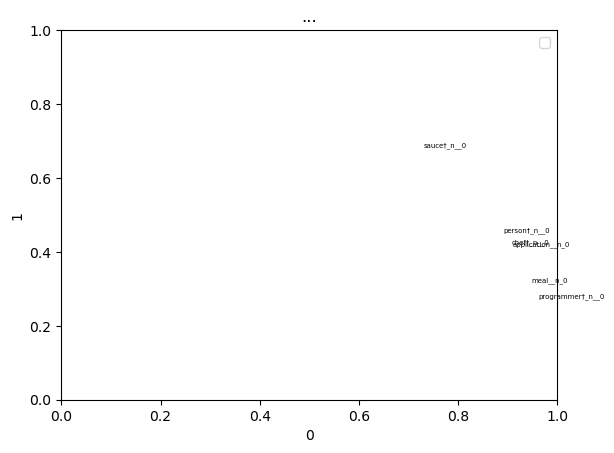

In [53]:
'''
We want to see to what exact quantum states the respective nouns are mapped. We define a qiskit circuit consisting of a Rx, Rz, and Rx gate and we look at the quantum 
states that the respective nouns are mapped to. 
'''
# import matplotlib
from qiskit import QuantumCircuit, Aer, execute

def getProbDist(listOfParams): 
    '''
    Given a list of parameters, this function creates a circuit and returns the state and the probability distribution of said state
    '''

    # Create a quantum circuit with one qubit
    qc = QuantumCircuit(1, 1)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)

    # Apply Rx and Rz gates
    qc.rx(listOfParams[0], 0)
    qc.rz(listOfParams[1], 0) 
    qc.rx(listOfParams[2], 0)


    # statevectors simulator for UNMEASURED CIRCUIT
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend=backend, shots = 1, memory = True)
    stateVector = job.result().get_statevector(qc)


    # Measure the qubit
    qc.measure(0, 0)  # Measure qubit 0 and store the result in classical bit 0

    # Draw the circuit (optional)
    # print("Quantum Circuit:")
    # qc.draw(output='mpl', filename = 'testtesttest.png')

    # Use the Aer simulator to execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist, stateVector


NounsAndVecs = {}
nounStateList = []

# for plotting the Bloch spheres
from qiskit.visualization import plot_bloch_multivector

for i in range(0, len(newWeights), 3): 

    params = newWeights[i:i+3]

    # print(newSmbls[i:i+3])

    # print(params)

    probDist, nounState = getProbDist(params)

    nounStateList.append(nounState)

    # plot bloch sphere 
    print('Symbol = ', str(newSmbls[i]))
    print('Statevector = ', str(nounState))
    plot_bloch_multivector(nounState, title=str(newSmbls[i]), filename = 'blochMultivector' + str(i) + '.png')

    NounsAndVecs[str(newSmbls[i])] = probDist

    # plot in 2-dim cartesian system
    plt.text(np.sqrt(probDist['0']), np.sqrt(probDist['1']), str(newSmbls[i]), fontsize = 5)


plt.title('...')
plt.ylabel('1')
plt.xlabel('0')
plt.legend()
plt.show()
# print(NounsAndVecs)



In [43]:
'''
We see that there is *no* system whatsoever. 
This might be due to the poor training as we can see in the plots below. 

I could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)

Later, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. 


NEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO 

'''

"\nWe see that there is *no* system whatsoever. \nThis might be due to the poor training as we can see in the plots below. \n\nI could do an animation here. And with the loss function being minimized we see the vectors of the different words changing (hopefully in some intuitive way)\n\nLater, we can use this 'proof' kind of idea to amplitude these things prior to the execution of the algorithm. \n\n\nNEXT STEP: INVESTIGATE THE VERBS AND RECONSTRUCT THE STATES THEY ARE MAPPED TO \n\n"

In [44]:
def VerbCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(3)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)
    qc.initialize(initial_state, 2)

    qc.h(range(3))

    # add CNOT gates 
    qc.crz(paramList[0], 2, 1)
    qc.crz(paramList[1], 1, 0)

    qc.h(range(3))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='verbCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(VerbCircuit([1,2], draw= True))



     ┌─────────────────┐┌───┐         ┌───────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├─────────┤ Rz(2) ├┤ H ├
     ├─────────────────┤├───┤┌───────┐└───┬───┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├┤ Rz(1) ├────■────┤ H ├
     ├─────────────────┤├───┤└───┬───┘  ┌───┐  └───┘
q_2: ┤ Initialize(1,0) ├┤ H ├────■──────┤ H ├───────
     └─────────────────┘└───┘           └───┘       


/home/bob/anaconda3/envs/code/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


{'000': 5.25780934030603e-06, '001': 1.66183287836071e-06, '010': 8.0643771242442e-07, '011': 1.66183287836071e-06, '100': 5.257933299646e-08, '101': 1.0835066732322e-07, '110': 3.4280652290523e-07, '111': 1.0835066732322e-07}


In [45]:
'''
Now, the same thing for adjectives
'''

def AdjectivesCircuit(paramList, draw = False): 
    '''
    returns probability distribution over possible states
    '''

    # create quantum circuit with three qubits 
    qc = QuantumCircuit(2)

    # Initialize the qubit to the |0⟩ state
    initial_state = [1, 0]  # Coefficients for the |0⟩ state
    qc.initialize(initial_state, 0)
    qc.initialize(initial_state, 1)

    qc.h(range(2))

    # add CNOT gates 
    qc.crz(paramList[0], 1, 0)

    qc.h(range(2))

    if draw: 
        print(qc)
        qc.draw(output='mpl', filename='adjCircuit.png')
    
    simulator = Aer.get_backend('statevector_simulator')

    # use this if you want the *complex* statevector!!
    # 
    # job = execute(qc, simulator)
    # result = job.result()
    # statevector = result.get_statevector()
    shots = 100000  # Number of times to run the circuit
    job = execute(qc, simulator, shots=shots)  # Execute the circuit
    result = job.result()
    counts = result.get_counts(qc)

    # Calculate the probability distribution
    prob_dist = {state: counts[state] / shots for state in counts}

    return prob_dist

print(AdjectivesCircuit([3.14], draw= True))



     ┌─────────────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ Initialize(1,0) ├┤ H ├┤ Rz(3.14) ├┤ H ├
     ├─────────────────┤├───┤└────┬─────┘├───┤
q_1: ┤ Initialize(1,0) ├┤ H ├─────■──────┤ H ├
     └─────────────────┘└───┘            └───┘
{'00': 2.50398321889424e-06, '01': 2.49999841465942e-06, '10': 2.49601995178691e-06, '11': 2.49999841465942e-06}


Final test accuracy: 0.0
Validation accuracy: 0.85


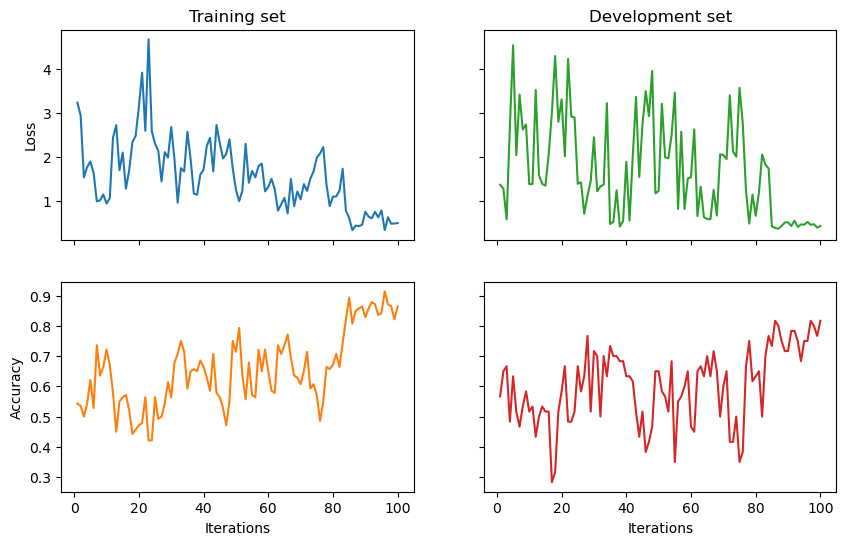

In [60]:
import matplotlib.pyplot as plt

trainer = trainerTK
model = modelTK
acc = accTK
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

# print test accuracy - tket
modelTK.load(trainerTK.log_dir + '/best_model.lt')
val_acc = accTK(modelTK(val_circuits), val_labels)
print('Validation accuracy:', val_acc.item())

In [47]:
'''
Now, for the density matrix part. 
We write a qiskit circuit and we predict, given the weights, the density matrices with the nouns missing
''' 
from qiskit import QuantumCircuit

a = modelNumpy.get_diagram_output(test_circuits)
print(len(a))

print(a)

# print(len(test_circuits))
# print(len(pred))

30
[[9.01978862e-01 9.80211379e-02]
 [9.38387437e-01 6.16125634e-02]
 [4.97803570e-01 5.02196430e-01]
 [5.71769114e-01 4.28230886e-01]
 [9.91287614e-01 8.71238647e-03]
 [4.48944104e-01 5.51055896e-01]
 [1.10000441e-01 8.89999559e-01]
 [2.38130346e-01 7.61869654e-01]
 [8.09675484e-01 1.90324516e-01]
 [8.80626730e-01 1.19373270e-01]
 [9.73664449e-01 2.63355514e-02]
 [3.17784610e-01 6.82215390e-01]
 [2.09002910e-01 7.90997090e-01]
 [9.86059005e-01 1.39409953e-02]
 [9.92978018e-01 7.02198173e-03]
 [2.61263257e-01 7.38736743e-01]
 [9.15930063e-04 9.99084070e-01]
 [5.54009006e-03 9.94459910e-01]
 [5.11240860e-04 9.99488759e-01]
 [7.79718157e-04 9.99220282e-01]
 [4.52944893e-04 9.99547055e-01]
 [9.85805248e-01 1.41947518e-02]
 [9.93018799e-01 6.98120135e-03]
 [9.92268606e-01 7.73139393e-03]
 [1.45971188e-01 8.54028812e-01]
 [8.91586375e-01 1.08413625e-01]
 [8.30924395e-04 9.99169076e-01]
 [9.93753040e-01 6.24696023e-03]
 [4.83486521e-04 9.99516513e-01]
 [6.53834066e-01 3.46165934e-01]]
